<a href="https://colab.research.google.com/github/hsreekumar/Data_capstone/blob/main/Stock_News_Scale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Sentiment Analysis using news headlines.

# Data set

Daily News for Stock Market Prediction
https://www.kaggle.com/datasets/aaron7sun/stocknews

We will predict whether the stock price for a given stock will raise or drop based on the related news headlines.

# Topic Covered

Pre-process Data

BERT Model scaled for input


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

#Encoding are in general UTF-8(default setting), Latin-1 (also known as ISO-8859-1) or Windows-1251
df=pd.read_csv('Combined_News_DJIA.csv', encoding = "ISO-8859-1")


# Data Inspection
First, let's have a look at our data set...
It seems our data is made of different news headlines related to a company and a label of whether the companies'stock price will increase or decrease.(0:decrease, 1: increase)

In [ ]:
df.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

# Train-Test Split

In time series problems, old data are used to predict later data. Therefore, we set test data to be the latest data.

In [ ]:
train = df[df['Date'] < '20150101']
test = df[df['Date'] > '20141231']

# Feature Transformation
**Text Preprocessing Functions**

Clean Text: Strips out non-alphabetical characters and converts the text to lowercase.

Tokenize and Remove Stopwords: Splits the text into individual words and removes common stopwords like "the" and "and."

Stem and Lemmatize: Reduces words to their root forms, making variations like "running" and "runs" into "run."

**Preprocess Headlines**

Combine Headlines: Gathers multiple headlines from a single day into one continuous text string.

Apply Preprocessing: Cleans, tokenizes, and normalizes the combined text, preparing it for further analysis.

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


# Preprocessing functions
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Replace non-alphabet characters with spaces
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Convert text to lowercase
    text = text.lower()
    return text

def tokenize_and_remove_stopwords(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return words

def stem_and_lemmatize(words):
    stemmed = [ps.stem(word) for word in words]
    lemmatized = [lemmatizer.lemmatize(word) for word in stemmed]
    return lemmatized

def preprocess_headline(headline):
    cleaned = clean_text(headline)
    tokens = tokenize_and_remove_stopwords(cleaned)
    normalized = stem_and_lemmatize(tokens)
    return " ".join(normalized)
# Encoding are in general UTF-8(default setting), Latin-1 (also known as ISO-8859-1) or Windows-1251
df=pd.read_csv('Combined_News_DJIA.csv', encoding = "ISO-8859-1")

train = df[df['Date'] < '20150101']
test = df[df['Date'] > '20141231']

# Preprocess the training headlines
data_train = train.iloc[:, 2:27]
data_train.columns = [str(i) for i in range(25)]

train_headlines = []
for row in range(0, len(data_train.index)):
    combined_headlines = ' '.join(str(x) for x in data_train.iloc[row, 0:25])
    preprocessed_headline = preprocess_headline(combined_headlines)
    train_headlines.append(preprocessed_headline)



# Preprocess the testing headlines
data_test = test.iloc[:, 2:27]
data_test.columns = [str(i) for i in range(25)]
test_headlines = []
for row in range(0, len(data_test.index)):
    combined_headlines = ' '.join(str(x) for x in data_test.iloc[row, 0:25])
    preprocessed_headline = preprocess_headline(combined_headlines)
    test_headlines.append(preprocessed_headline)

# Create the target labels
y_train = train['Label'].values
y_test = test['Label'].values

# Create Bag of Words representation with bigrams
countvector = CountVectorizer(ngram_range=(2, 2))
X_train = countvector.fit_transform(train_headlines)
X_test = countvector.transform(test_headlines)

# Print the shapes of the training and testing sets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# Print a sample of the preprocessed headlines and their Bag of Words representation
print("\nSample of preprocessed headlines:")
print(train_headlines[:2])
print("\nBag of Words representation (feature names):")
print(countvector.get_feature_names_out()[:10])  # Displaying first 10 feature names for brevity
print("\nBag of Words representation (dense matrix):")
print(X_train.toarray()[:2])  # Displaying first 2 rows for brevity


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Training set shape: (1863, 374550)
Testing set shape: (378, 374550)

Sample of preprocessed headlines:
['b georgia down two russian warplan countri move brink war b break musharraf impeach b russia today column troop roll south ossetia footag fight youtub b russian tank move toward capit south ossetia reportedli complet destroy georgian artilleri fire b afghan child rape impun u n offici say sick three year old rape noth b russian tank enter south ossetia whilst georgia shoot two russian jet b break georgia invad south ossetia russia warn would interven side b enemi combat trial noth sham salim haman sentenc year kept longer anyway feel like b georgian troop retreat osettain capit presum leav sever hundr peopl kill video b u prep georgia war russia b rice give green light israel attack iran say u veto isra militari op b announc class action lawsuit behalf american public fbi b russia georgia war nyt top stori open ceremoni olymp fuck disgrac yet proof declin journal b china tell bush s

# BERT Model scaled for entire dataset
**Batch Processing**:
The DataLoader handles mini-batch processing by dividing the dataset into smaller batches (BATCH_SIZE), which helps in efficient memory management and accelerates training.

 During training, each batch is loaded sequentially, allowing the model to process smaller chunks of data.

  The shuffle=True parameter ensures that the data is shuffled at the start of each epoch, preventing the model from learning the order of the data.
  
  Gradient clipping (nn.utils.clip_grad_norm_) is used to prevent exploding gradients by capping the gradients during backpropagation.

**Data Parallelism**:
The model is wrapped with nn.DataParallel to parallelize it across multiple GPUs.

**Memory Management**:
Efficient data loading with multiple worker threads.
Avoid unnecessary large memory allocations.

The DataLoader is configured with multiple workers (num_workers=4). This allows for efficient data loading in parallel, reducing the CPU bottleneck and making better use of available memory.

Tensors are moved to the GPU (device) only when they are needed for computation. This prevents unnecessary memory usage on the GPU.


Epoch 1/20
----------
Train loss 0.7454870068109952 accuracy 0.47987117552334946
Val loss 0.6950636804103851 accuracy 0.5052910052910052
Epoch 2/20
----------
Train loss 0.7297892050865369 accuracy 0.500805152979066
Val loss 0.6932498464981715 accuracy 0.5105820105820106
Epoch 3/20
----------
Train loss 0.7441219789350134 accuracy 0.49114331723027377
Val loss 0.6903265838821729 accuracy 0.5502645502645502
Epoch 4/20
----------
Train loss 0.7484543522198995 accuracy 0.48470209339774556
Val loss 0.6873603214820226 accuracy 0.5449735449735449
Epoch 5/20
----------
Train loss 0.7357596220114292 accuracy 0.5190552871712292
Val loss 0.6773275335629781 accuracy 0.5978835978835979
Epoch 6/20
----------
Train loss 0.7153836712877975 accuracy 0.5394524959742351
Val loss 0.6308215123911699 accuracy 0.6666666666666666
Epoch 7/20
----------
Train loss 0.6749368442429436 accuracy 0.5845410628019324
Val loss 0.6456417279938856 accuracy 0.6243386243386243
Epoch 8/20
----------
Train loss 0.60495005840

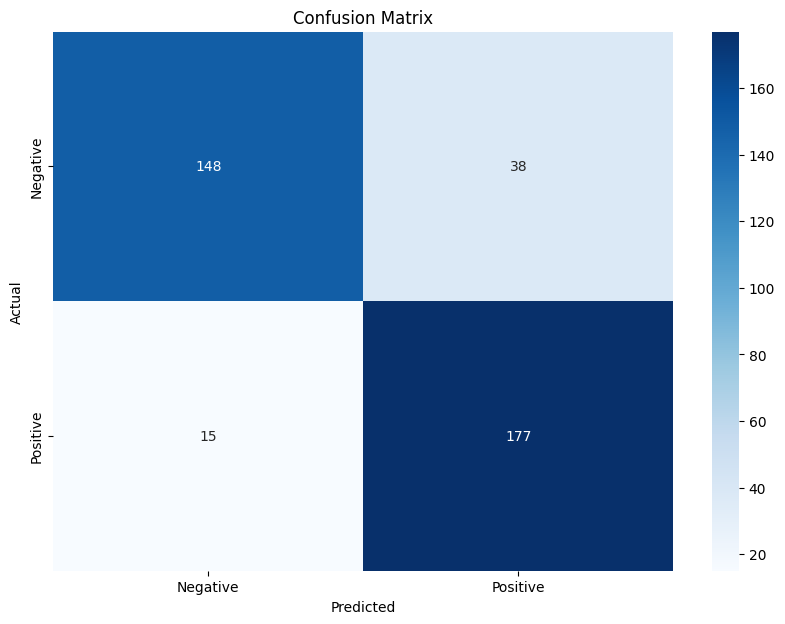


Accuracy: 0.86


In [ ]:
import pandas as pd
import re
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import warnings
import logging


# Suppress specific warning messages
warnings.filterwarnings("ignore")


# Set logging level for transformers and other libraries
logging.basicConfig(level=logging.ERROR)


# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class NewsDataset(Dataset):
    def __init__(self, headlines, labels, tokenizer, max_len):
        self.headlines = headlines
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, item):
        headline = str(self.headlines[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            headline,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,  # Explicitly specify truncation
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'headline_text': headline,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(headlines, labels, tokenizer, max_len, batch_size):
    ds = NewsDataset(
        headlines=headlines,
        labels=labels,
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

BATCH_SIZE = 16
MAX_LEN = 128

train_data_loader = create_data_loader(train_headlines, y_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_headlines, y_test, tokenizer, MAX_LEN, BATCH_SIZE)


EPOCHS = 20
PATIENCE = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
class NewsClassifier(nn.Module):
    def __init__(self, n_classes):
        super(NewsClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 256)
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls_output = outputs.pooler_output
        x = self.dropout(cls_output)
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        return self.fc2(x)


model = NewsClassifier(n_classes=2)
model = nn.DataParallel(model)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)

# Define the total number of training steps
total_steps = len(train_data_loader) * EPOCHS

# Define the learning rate scheduler with a warm-up period
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # Warm-up for 10% of the steps
    num_training_steps=total_steps
)

# Define the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

# Training function
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

# Evaluation function
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)


best_loss = float('inf')
best_accuracy = 0
best_model = None
patience_counter = 0

# Training loop with early stopping
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_headlines)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        test_data_loader,
        loss_fn,
        device,
        len(test_headlines)
    )

    print(f'Val loss {val_loss} accuracy {val_acc}')

    # Check for early stopping
    if best_accuracy < val_acc:
        best_loss = val_loss
        best_accuracy = val_acc
        best_model = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        print("Early stopping triggered")
        break

# Load the best model
model.load_state_dict(best_model)

# Evaluation on test set
y_test_pred = []
y_test_true = []

with torch.no_grad():
    for d in test_data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)

        y_test_pred.extend(preds)
        y_test_true.extend(labels)

y_test_pred = torch.stack(y_test_pred).cpu()
y_test_true = torch.stack(y_test_true).cpu()

# Compute and print confusion matrix and classification report
print("\nConfusion Matrix (test):")
cm = confusion_matrix(y_test_true, y_test_pred)
print(cm)

print("\nClassification Report (test):")
print(classification_report(y_test_true, y_test_pred))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print accuracy
accuracy = accuracy_score(y_test_true, y_test_pred)
print(f"\nAccuracy: {accuracy:.2f}")
